<a href="https://colab.research.google.com/github/ArinaOwl/multilayer_perceptron/blob/main/MultilayerPerceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Многослойный персептрон

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from argparse import Namespace
from tqdm import tqdm, tqdm_notebook

## Класс многослойного персептрона

In [ ]:
class MultilayerPerceptron(nn.Module): # наследует nn.Module
    def __init__(self, input_dim, output_dim, hidden_dim = 100, num_hidden = 1,
                 activation = 'ReLU', apply_dropout = False, p = 0.5, apply_batchnorm = False):  # конструктор класса
        """
        Аргументы:
            input_dim (int): размер входных векторов
            hidden_dim (int): размер скрытых слоев
            output_dim (int): размер выходного вектора
            num_dim (int): количество скрытых слоев
            activation (str): функция активации ('ReLU', 'sigmoid', 'tanh')
            apply_dropout (bool): флаг для метода прореживания
            p (int): вероятность отброса для метода прореживания
            apply_batchnorm (bool): флаг для нормализации батчей
        """
        super(MultilayerPerceptron, self).__init__() # инициализация родительского класса
        activation_choice = {'ReLU': F.relu,
                             'sigmoid': F.sigmoid,
                             'tanh': F.tanh}
        self.activation_func = activation_choice[activation]
        self.apply_dropout = apply_dropout
        self.apply_batchnorm = apply_batchnorm
        self.p = p
        self.fc_head = nn.Linear(input_dim, hidden_dim) # класс, рассчитывающий Wx + b
        self.fc_blocks = [nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden - 1)]
        if self.apply_batchnorm:
            self.fc_blocks_bn = [nn.BatchNorm1d(hidden_dim) for i in range(num_hidden - 1)]
        self.fc_tail = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x_in, apply_softmax = False): #прямой проход классификатора
        """
        Аргументы:
            x_in (torch.Tensor): входной тензор данных
            apply_softmax (bool): флаг для многомерной логистической функции активации
        """
        intermediate = self.activation_func(self.fc_head(x_in))
        for i in range(len(self.fc_blocks)):
            if self.apply_dropout:
                intermediate = F.dropout(intermediate, p = self.p, training = self.training)
            intermediate = self.activation_func(self.fc_blocks[i](intermediate))
            if self.apply_batchnorm:
                intermediate = self.fc_blocks_bn[i](intermediate)
        if self.apply_dropout:
            intermediate = F.dropout(intermediate, p = self.p, training = self.training)
        output = self.fc_tail(intermediate)

        if apply_softmax:
            output = F.softmax(output, dim = 1)
        return output

## Класс набора данных

In [ ]:
class SomeDataset(Dataset):
    def __init__(self, some_df, feature_cols, target_col, 
                 train_size = 0.07, test_size = 0.9):
        """
        Аргументы:
            some_df (pandas.DataFrame): датафрейм с предварительно обработанными данными
            feature_cols (list(str)): названия колонок-признаков
            target_col (str): название целевой колонки
            train_size (float): доля данных на обучающую выборку
            test_size (float): доля данных на контрольную выборку
        """

        self.some_df = some_df
        
        self.feature_cols = feature_cols
        self.target_col = target_col

        self.test_df = self.some_df.sample(frac = test_size)
        self.test_size = len(self.test_df)

        self.train_df = self.some_df.drop(self.test_df.index).sample(frac = train_size / (1 - test_size))
        self.train_size = len(self.train_df)
        
        self.val_df = self.some_df.drop(self.train_df.index).drop(self.test_df.index)
        self.validation_size = len(self.val_df)

        self.mean = self.train_df[feature_cols].mean(axis = 0)
        self.std = self.train_df[feature_cols].std(axis = 0)

        self.train_df[feature_cols] = (self.train_df[feature_cols] - self.mean)/self.std
        self.val_df[feature_cols] = (self.val_df[feature_cols] - self.mean)/self.std
        self.test_df[feature_cols] = (self.test_df[feature_cols] - self.mean)/self.std
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    def set_split(self, split="train"):
        """ Выбор фрагментов набора данных по столбцу из объекта dataframe

        Аргуметы:
            split (str): "train" (обучающий), "val" (проверочный) или "test" (контрольный)
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """ Обращение к элементам текущего фрагмента по индексу

        Аргументы:
            index (int): индекс точки данных 
        Возвращает:
            словарь, содержащий точки данных
        """
        row = self._target_df.iloc[index]

        features = torch.FloatTensor(row[self.feature_cols])
        label = row[self.target_col]

        return features, label

    def get_num_batches(self, batch_size):
        """
        Аргументы:
            batch_size (int): размер пакета
        Возвращает:
            количество пакетов в наборе данных
        """
        return len(self) // batch_size
    
    def get_num_targets(self):
        """
            Количество различных значений целевой переменной
        """
        return self.some_df[self.target_col].nunique()

## Функции, используемые при обучении

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """ Эпоха обучения
    Аргументы:
        model (MultilayerPerceptron): модель
        train_loader (DataLoader): загрузчик данных
        criterion: функция потерь
        optimizer: оптимизатор
    Возвращает:
        кортеж из среднего значения функции потерь и оценки точности
    """
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    # процедура обучения
    for features, labels in train_loader:
        # получение данных
        features = features.to(args.device)
        labels = labels.to(args.device)

        # обнуление градиентов
        optimizer.zero_grad()

        # вычисление прямого прохода модели
        outputs = model(features)

        # вычисление функции потерь
        loss = criterion(outputs, labels)

        # вычисление градиентов на основании функции потерь
        loss.backward()

        # обновление значений параметров по градиентам
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * features.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += features.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    """ Эпоха оценки
    Аргументы:
        model (MultilayerPerceptron): модель
        val_loader (DataLoader): загрузчик данных
        criterion: функция потерь
    Возвращает:
        кортеж из среднего значения функции потерь и оценки точности
    """
    # перевод модели в состояние оценки  
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    # процедура оценки
    for features, labels in val_loader:
        # получение входных значений      
        features = features.to(args.device)
        labels = labels.to(args.device)
        
        with torch.set_grad_enabled(False):
            # вычисление прямого прохода модели
            outputs = model(features)

            # вычисление функции потерь
            loss = criterion(outputs, labels)

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * features.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += features.size(0)
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(dataset, model, epochs, batch_size):
    """ Обучение сети
    Аргументы:
        dataset (SomeDataset): набор данных
        model (MultilayerPerceptron): модель
        epochs (int): количество эпох обучения
        batch_size (int): размер мини-пакетов
    Возвращает:
        историю обучения в виде списка, 
        содержащего данные потерь и точностей для каждой эпохи
    
    """  
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            dataset.set_split('train')            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            dataset.set_split('val')            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

## Дополнительные функции используемые при классификации 

In [ ]:
def set_seed_everywhere(seed, cuda):
    """Фиксирование seed
    Аргументы:
        seed (int)
        cuda (bool): флаг для использования GPU
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [ ]:
def create_plot_loss_or_acc(train, val, label):
    """Создание графиков
    Аргументы:
        train (list): список показателей на тренировочной выборке
        val (list): список показателей на проверочных данных
        label (str): метка ("loss"/"acc")
    """
    plt.figure(figsize=(15, 9))
    plt.plot(train, label="train")
    plt.plot(val, label="val")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel(label)
    plt.show()

In [ ]:
def predict(model, test_loader):
    """Предсказание модели
    Аргументы:
        model (MultilayerPerceptron): модель
        test_loader (DataLoader): загрузчик данных
    Возвращает:
        список предсказаний модели
    """
    with torch.no_grad():
        logits = []
    
        for features, label in test_loader:
            features = features.to(args.device)
            model.eval()
            outputs = model(features, apply_softmax = True).cpu()
            logits.append(outputs)
            
    return torch.cat(logits).numpy()

## Подготовка к обучению 

In [ ]:
args = Namespace(
    datafilename = 'Skyserver_12_30_2019 4_49_58 PM.csv',
    feature_cols = ['u', 'g', 'r', 'i', 'z', 'redshift'],
    target_col = 'classid',
    # Гиперпараметры модели
    hidden_dim = 125,
    num_hidden = 2,
    activation = 'ReLU',
    apply_dropout = True,
    p = 0.5,
    apply_batchnorm = True,
    # Гиперпараметры тренировки
    seed=42,
    num_epochs=30,
    learning_rate=0.001,
    batch_size=200,
    # Параметры вычислений
    cuda=False
)
    
# Проверка на возможность использования GPU
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")    
print("Using CUDA: {}".format(args.cuda))

set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


## Цикл обучения перцептрона

In [ ]:
data = pd.read_csv(args.datafilename)
data['classid'] = data['class'].map({'STAR': 0, 'GALAXY': 1, 'QSO': 2}) 

dataset = SomeDataset(data, args.feature_cols, args.target_col)

model = MultilayerPerceptron(len(args.feature_cols), dataset.get_num_targets(), 
                                     args.hidden_dim, args.num_hidden, args.activation, 
                                     args.apply_dropout, args.p, args.apply_batchnorm)
history = train(dataset, model, epochs = args.num_epochs, batch_size = args.batch_size)

epoch:   3%|▎         | 1/30 [00:08<04:10,  8.65s/it]


Epoch 001 train_loss: 1.0193     val_loss 0.6952 train_acc 0.5203 val_acc 0.7507


epoch:   7%|▋         | 2/30 [00:17<04:02,  8.65s/it]


Epoch 002 train_loss: 0.5896     val_loss 0.5036 train_acc 0.7996 val_acc 0.8217


epoch:  10%|█         | 3/30 [00:26<03:54,  8.69s/it]


Epoch 003 train_loss: 0.4367     val_loss 0.3837 train_acc 0.8661 val_acc 0.8873


epoch:  13%|█▎        | 4/30 [00:40<04:28, 10.33s/it]


Epoch 004 train_loss: 0.3320     val_loss 0.2988 train_acc 0.9219 val_acc 0.9267


epoch:  17%|█▋        | 5/30 [00:51<04:21, 10.46s/it]


Epoch 005 train_loss: 0.2581     val_loss 0.2476 train_acc 0.9461 val_acc 0.9447


epoch:  20%|██        | 6/30 [01:04<04:30, 11.28s/it]


Epoch 006 train_loss: 0.2194     val_loss 0.2097 train_acc 0.9546 val_acc 0.9530


epoch:  23%|██▎       | 7/30 [01:15<04:22, 11.43s/it]


Epoch 007 train_loss: 0.1892     val_loss 0.1881 train_acc 0.9586 val_acc 0.9603


epoch:  27%|██▋       | 8/30 [01:26<04:03, 11.07s/it]


Epoch 008 train_loss: 0.1726     val_loss 0.1717 train_acc 0.9634 val_acc 0.9627


epoch:  30%|███       | 9/30 [01:35<03:41, 10.57s/it]


Epoch 009 train_loss: 0.1556     val_loss 0.1574 train_acc 0.9676 val_acc 0.9643


epoch:  33%|███▎      | 10/30 [01:44<03:19, 10.00s/it]


Epoch 010 train_loss: 0.1453     val_loss 0.1495 train_acc 0.9687 val_acc 0.9653


epoch:  37%|███▋      | 11/30 [01:54<03:13, 10.20s/it]


Epoch 011 train_loss: 0.1376     val_loss 0.1393 train_acc 0.9706 val_acc 0.9677


epoch:  40%|████      | 12/30 [02:04<02:59,  9.99s/it]


Epoch 012 train_loss: 0.1274     val_loss 0.1347 train_acc 0.9714 val_acc 0.9660


epoch:  43%|████▎     | 13/30 [02:13<02:46,  9.80s/it]


Epoch 013 train_loss: 0.1238     val_loss 0.1281 train_acc 0.9730 val_acc 0.9677


epoch:  47%|████▋     | 14/30 [02:22<02:33,  9.62s/it]


Epoch 014 train_loss: 0.1153     val_loss 0.1213 train_acc 0.9737 val_acc 0.9693


epoch:  50%|█████     | 15/30 [02:31<02:21,  9.40s/it]


Epoch 015 train_loss: 0.1058     val_loss 0.1234 train_acc 0.9770 val_acc 0.9700


epoch:  53%|█████▎    | 16/30 [02:40<02:09,  9.26s/it]


Epoch 016 train_loss: 0.1034     val_loss 0.1136 train_acc 0.9761 val_acc 0.9723


epoch:  57%|█████▋    | 17/30 [02:50<02:01,  9.34s/it]


Epoch 017 train_loss: 0.1021     val_loss 0.1101 train_acc 0.9786 val_acc 0.9723


epoch:  60%|██████    | 18/30 [02:59<01:51,  9.32s/it]


Epoch 018 train_loss: 0.0967     val_loss 0.1095 train_acc 0.9771 val_acc 0.9710


epoch:  63%|██████▎   | 19/30 [03:08<01:41,  9.26s/it]


Epoch 019 train_loss: 0.0942     val_loss 0.1061 train_acc 0.9794 val_acc 0.9747


epoch:  67%|██████▋   | 20/30 [03:18<01:33,  9.31s/it]


Epoch 020 train_loss: 0.0897     val_loss 0.1048 train_acc 0.9810 val_acc 0.9747


epoch:  70%|███████   | 21/30 [03:27<01:23,  9.33s/it]


Epoch 021 train_loss: 0.0908     val_loss 0.1061 train_acc 0.9791 val_acc 0.9740


epoch:  73%|███████▎  | 22/30 [03:36<01:14,  9.34s/it]


Epoch 022 train_loss: 0.0844     val_loss 0.1094 train_acc 0.9814 val_acc 0.9727


epoch:  77%|███████▋  | 23/30 [03:47<01:07,  9.70s/it]


Epoch 023 train_loss: 0.0849     val_loss 0.0994 train_acc 0.9807 val_acc 0.9767


epoch:  80%|████████  | 24/30 [03:56<00:56,  9.44s/it]


Epoch 024 train_loss: 0.0835     val_loss 0.1021 train_acc 0.9816 val_acc 0.9773


epoch:  83%|████████▎ | 25/30 [04:05<00:46,  9.24s/it]


Epoch 025 train_loss: 0.0778     val_loss 0.0997 train_acc 0.9823 val_acc 0.9753


epoch:  87%|████████▋ | 26/30 [04:14<00:36,  9.21s/it]


Epoch 026 train_loss: 0.0752     val_loss 0.0982 train_acc 0.9823 val_acc 0.9767


epoch:  90%|█████████ | 27/30 [04:25<00:29,  9.89s/it]


Epoch 027 train_loss: 0.0761     val_loss 0.0941 train_acc 0.9820 val_acc 0.9783


epoch:  93%|█████████▎| 28/30 [04:35<00:19,  9.74s/it]


Epoch 028 train_loss: 0.0717     val_loss 0.0936 train_acc 0.9831 val_acc 0.9780


epoch:  97%|█████████▋| 29/30 [04:45<00:09,  9.88s/it]


Epoch 029 train_loss: 0.0761     val_loss 0.1017 train_acc 0.9826 val_acc 0.9770


epoch: 100%|██████████| 30/30 [04:55<00:00,  9.85s/it]


Epoch 030 train_loss: 0.0732     val_loss 0.1015 train_acc 0.9823 val_acc 0.9770


## Визуализация обучения 

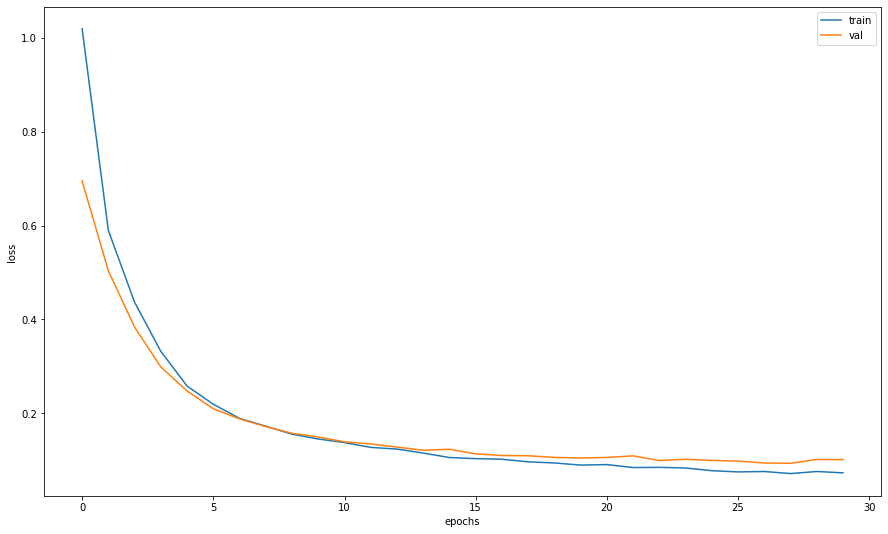

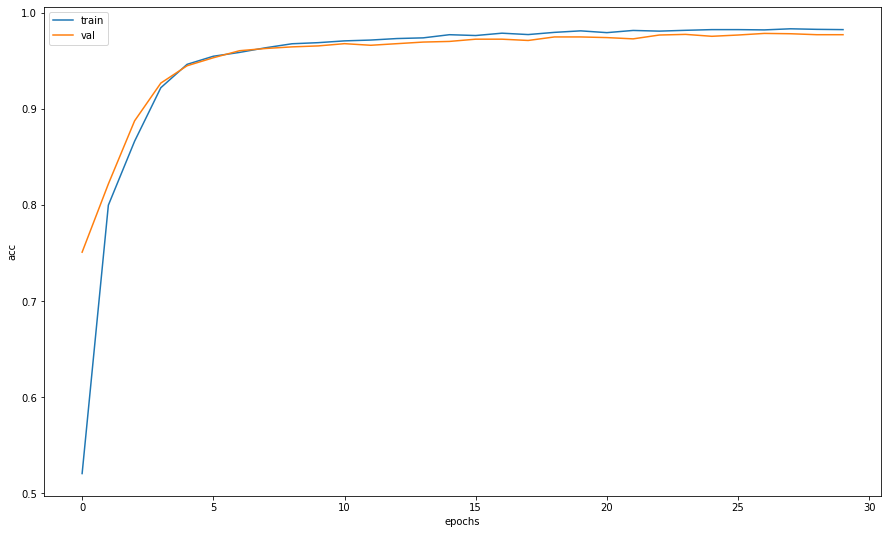

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
create_plot_loss_or_acc(loss, val_loss, "loss")
create_plot_loss_or_acc(acc, val_acc, "acc")

## Демонстрация работы 

In [ ]:
dataset.set_split('test')
test_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)
labels1 = []
for features, labels in test_loader:
    labels1 = np.concatenate((labels1, np.array(labels)), axis=0)
labels1 = labels1.astype('int') 
print(len(labels1))
print(labels1)
    
result = predict(model, test_loader)
result_id = torch.argmax(torch.Tensor(result), 1)
print(len(result_id))
print(np.array(result_id))

90000
[0 1 0 ... 0 2 0]
90000
[0 1 0 ... 0 2 0]


In [ ]:
print(np.array(result_id) - np.array(labels1))
print("Количество неверно классифицированных объектов: ", 
      np.count_nonzero(np.array(result_id) - np.array(labels1)))
print("Точность модели на контрольной выборке: ", 
      (len(np.array(labels1))-np.count_nonzero(np.array(result_id) - np.array(labels1)))/len(np.array(labels1)))

[0 0 0 ... 0 0 0]
Количество неверно классифицированных объектов:  2048
Точность модели на контрольной выборке:  0.9772444444444445
